In [1]:
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('hybrid_malicious_phish.csv', encoding='ISO-8859-1')

print(df.shape)
df.head()


(817157, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
df = df.drop_duplicates(subset='url')
df.type.value_counts()

type
benign        428111
phishing      258278
defacement     95306
malware        25347
Name: count, dtype: int64

In [4]:
from sklearn.utils import resample

# Separate classes
df_benign = df[df['type'] == 'benign']
df_deface = df[df['type'] == 'defacement']
df_phish = df[df['type'] == 'phishing']
df_malware = df[df['type'] == 'malware']

# Downsample benign
df_benign_down = resample(df_benign,replace=False,n_samples=258278,random_state=42)

# Combine with other classes
df_balanced = pd.concat([df_benign_down, df_deface, df_phish, df_malware])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df=df_balanced
print(df.shape)
df.head()
df.type.value_counts()


(637209, 2)


type
benign        258278
phishing      258278
defacement     95306
malware        25347
Name: count, dtype: int64

## Plotting Wordcloud

In [5]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']


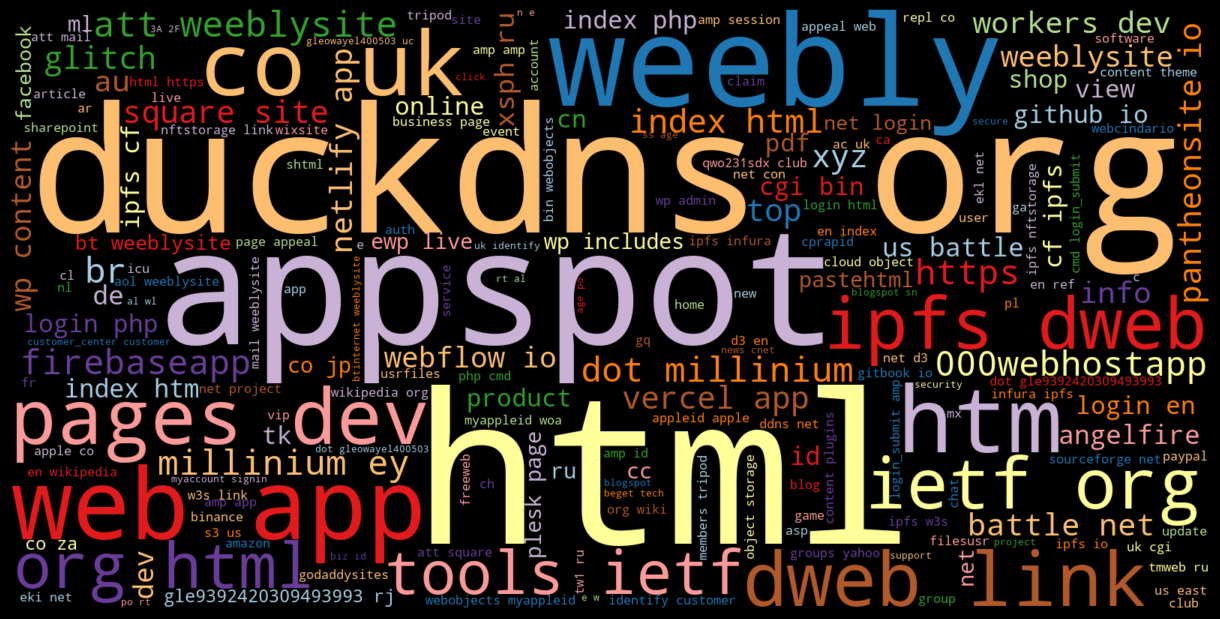

In [6]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

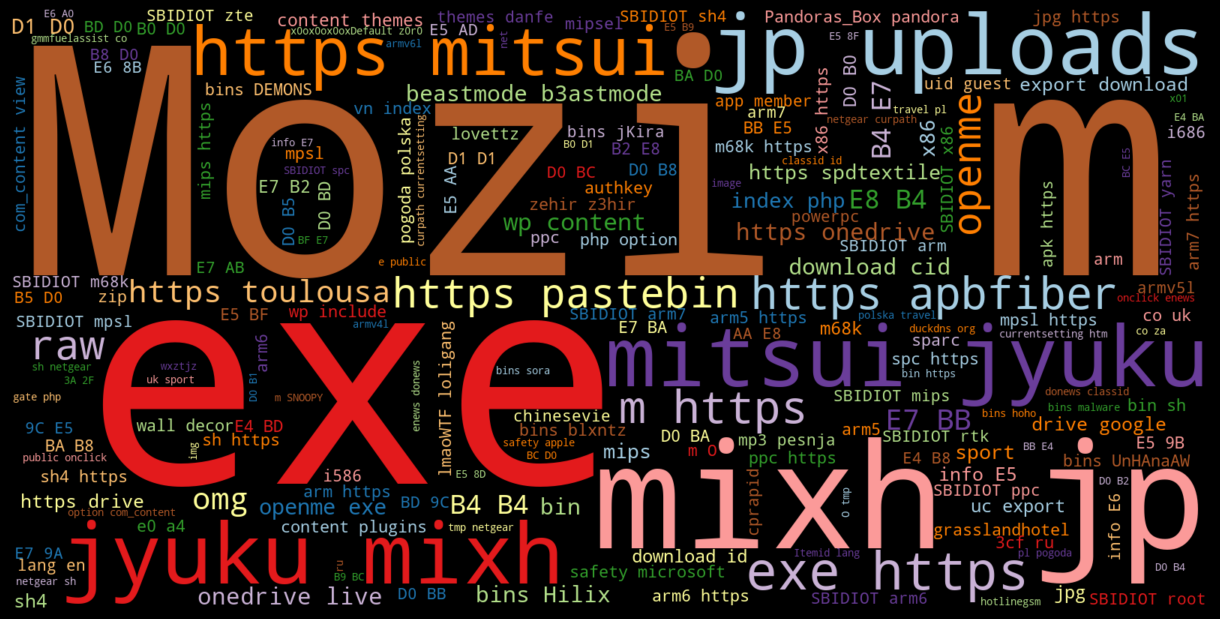

In [7]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

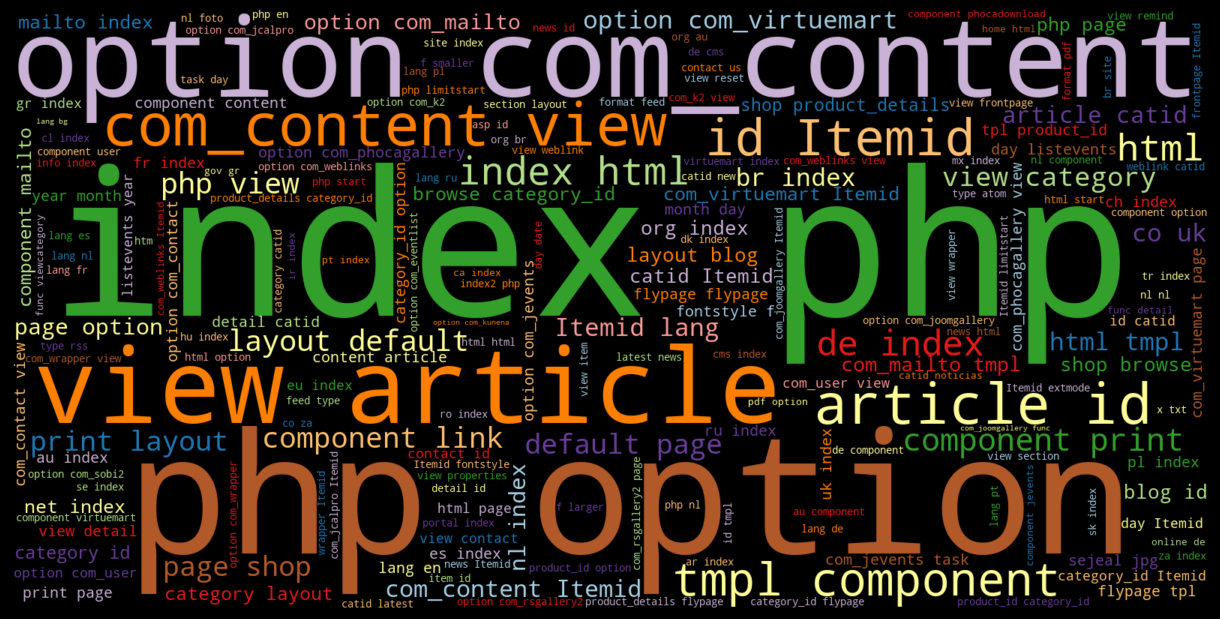

In [8]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

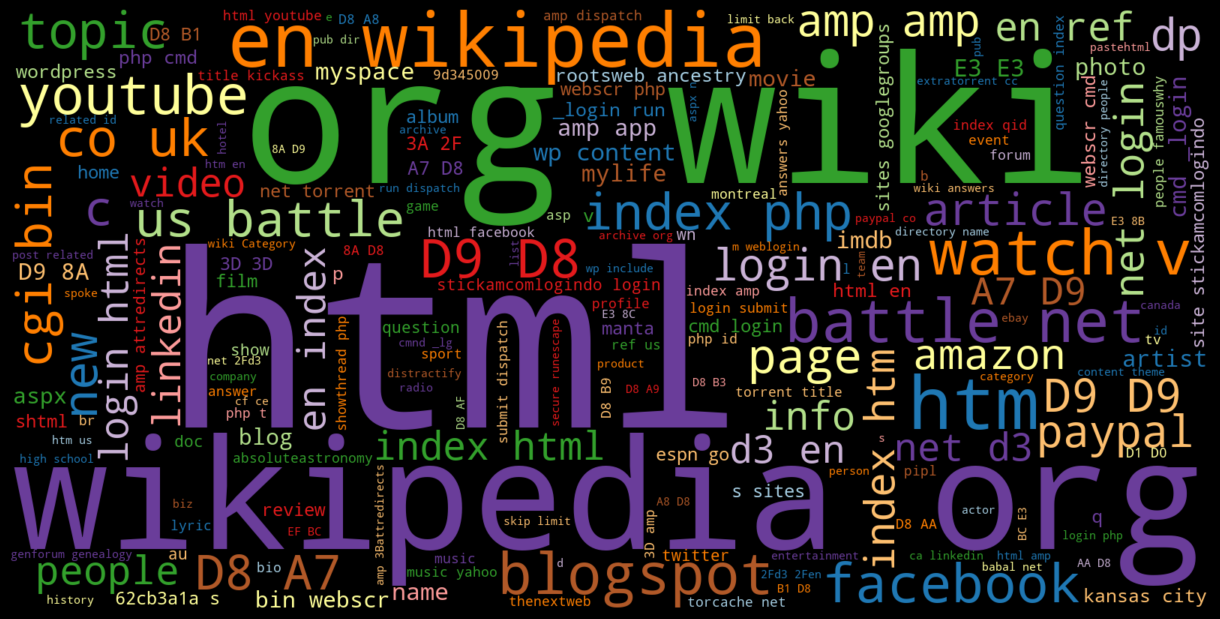

In [9]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Feature Engineering

In [10]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [11]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [12]:
from collections import Counter
import math
from tqdm import tqdm
def count_atrate(url):
    return url.count('@')
df['count@'] = df['url'].apply(lambda i: count_atrate(i))

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def shortening_service(url):
    pattern = (
        r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
        r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
        r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
        r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
        r'db\.tt|qr\.ae|adf\.ly|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|ity\.im|q\.gs|po\.st|bc\.vc|'
        r'twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|prettylinkpro\.com|'
        r'scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|tr\.im|link\.zip\.net'
    )
    match = re.search(pattern, url)
    return 1 if match else 0

# Apply to DataFrame
df['short_url'] = df['url'].apply(shortening_service)
tqdm.pandas()
def shannon_entropy(url):
    if not isinstance(url, str) or len(url) == 0:
        return 0
    p, lns = Counter(url), float(len(url))
    return -sum(count / lns * math.log2(count / lns) for count in p.values())

df['url_entropy'] = df['url'].progress_apply(shannon_entropy)

100%|██████████| 637209/637209 [00:04<00:00, 148740.40it/s]


In [13]:
def count_https(url):
    return url.count('https')
df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')
df['count-http'] = df['url'].apply(lambda i : count_http(i))

def count_ques(url):
    return url.count('?')
df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')
df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')
df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))
df['url_length'] = df['url'].apply(lambda i: url_length(i))

def hostname_length(url):
    return len(urlparse(url).netloc)
df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

def suspicious_words(url):
    match = re.search('login|signin|bank|account|update|free|secure|ebayisapi|webscr|verify|bonus|paypal|payment|service|alert|confirm|click|submit|password|reset|urgent|limited|lucky|prize|refund|access|support',
                        url, re.IGNORECASE)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,use_of_ip,abnormal_url,count@,count_dir,short_url,url_entropy,count-https,count-http,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,gayclassifieds.org/75__Quebec_/,benign,0,0,0,2,0,4.171465,0,0,0,0,0,31,0,0,2,23
1,howardtullman.com/projects/swinging_on_a_star/...,benign,0,0,0,3,0,4.327108,0,0,0,0,0,56,0,0,0,48
2,accnt-notice.com,phishing,0,0,0,0,0,3.125000,0,0,0,1,0,16,0,0,0,14
3,http://torcache.net/torrent/0CA4C8E7FB26A354B1...,benign,0,1,0,2,0,5.009796,0,1,1,0,1,146,12,0,23,104
4,http://soothingpainrelief.com/index.php?option...,defacement,0,1,0,1,0,4.530269,0,1,1,0,4,90,22,0,3,72


In [14]:
from urllib.parse import urlparse,parse_qs
from tld import get_tld
import tldextract

def count_params(url):
    return len(parse_qs(urlparse(url).query))
df['count_params'] = df['url'].apply(lambda i: count_params(i))

# 1. First Directory Length
def fd_length(url):
    try:
        ext = tldextract.extract(url)
        domain = ext.domain
        return len(domain) if domain else 0
    except:
        return 0  # fallback

# 2. Length of Top-Level Domain (TLD)
def extract_tld(url):
    try:
        return get_tld(url, fail_silently=True)
    except:
        return ''
df['tld'] = df['url'].apply(extract_tld)

def tld_length(tld):
    return len(tld) if tld else 0

df['tld_length'] = df['tld'].apply(tld_length)

# 3. Number of Subdomains
def num_subdomains(url):
    ext = tldextract.extract(url)
    if ext.subdomain:
        return ext.subdomain.count('.') + 1
    return 0

df['num_subdomains'] = df['url'].apply(num_subdomains)


In [15]:
df = df.drop("tld",axis=1)

In [16]:
def count_non_alphanumeric(url):
    return sum(1 for ch in url if not ch.isalnum())
df['count_non_alphanumeric'] = df['url'].apply(lambda i: count_non_alphanumeric(i))


def has_php(url):
    return int('php' in url.lower())
df['has_php'] = df['url'].apply(lambda i: has_php(i))

In [17]:
df.head()

,url,type,use_of_ip,abnormal_url,count@,count_dir,short_url,url_entropy,count-https,count-http,...,url_length,hostname_length,sus_url,count-digits,count-letters,count_params,tld_length,num_subdomains,count_non_alphanumeric,has_php
0,gayclassifieds.org/75__Quebec_/,benign,0,0,0,2,0,4.171465,0,0,...,31,0,0,2,23,0,0,0,6,0
1,howardtullman.com/projects/swinging_on_a_star/...,benign,0,0,0,3,0,4.327108,0,0,...,56,0,0,0,48,0,0,0,8,0
2,accnt-notice.com,phishing,0,0,0,0,0,3.125000,0,0,...,16,0,0,0,14,0,0,0,2,0
3,http://torcache.net/torrent/0CA4C8E7FB26A354B1...,benign,0,1,0,2,0,5.009796,0,1,...,146,12,0,23,104,1,3,0,19,0
4,http://soothingpainrelief.com/index.php?option...,defacement,0,1,0,1,0,4.530269,0,1,...,90,22,0,3,72,4,3,0,15,1


In [18]:
import whois
print(whois.whois('example.com'))

{
  "domain_name": "EXAMPLE.COM",
  "registrar": "RESERVED-Internet Assigned Numbers Authority",
  "registrar_url": "http://res-dom.iana.org",
  "reseller": null,
  "whois_server": "whois.iana.org",
  "referral_url": null,
  "updated_date": "2024-08-14 07:01:34",
  "creation_date": "1995-08-14 04:00:00",
  "expiration_date": "2025-08-13 04:00:00",
  "name_servers": [
    "A.IANA-SERVERS.NET",
    "B.IANA-SERVERS.NET"
  ],
  "status": [
    "clientDeleteProhibited https://icann.org/epp#clientDeleteProhibited",
    "clientTransferProhibited https://icann.org/epp#clientTransferProhibited",
    "clientUpdateProhibited https://icann.org/epp#clientUpdateProhibited"
  ],
  "emails": null,
  "dnssec": "signedDelegation",
  "name": null,
  "org": null,
  "address": null,
  "city": null,
  "state": null,
  "registrant_postal_code": null,
  "country": null
}


In [19]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'count@', 'count_dir',
       'short_url', 'url_entropy', 'count-https', 'count-http', 'count?',
       'count-', 'count=', 'url_length', 'hostname_length', 'sus_url',
       'count-digits', 'count-letters', 'count_params', 'tld_length',
       'num_subdomains', 'count_non_alphanumeric', 'has_php'],
      dtype='object')

In [20]:
df['type'].value_counts()

type
benign        258278
phishing      258278
defacement     95306
malware        25347
Name: count, dtype: int64

## EDA

## 1. Distribution of use_of_ip

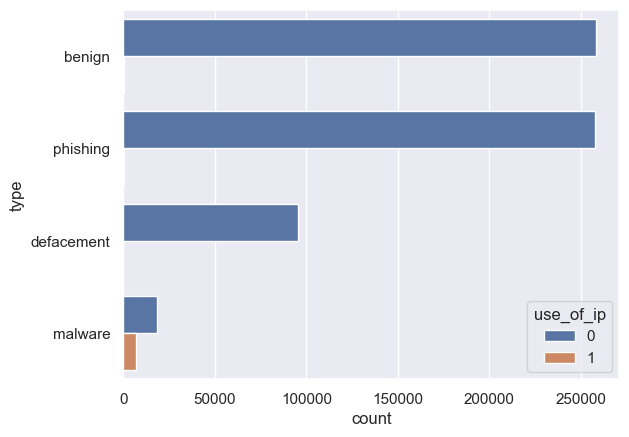

In [21]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")


## 2. Distribution of abnormal url

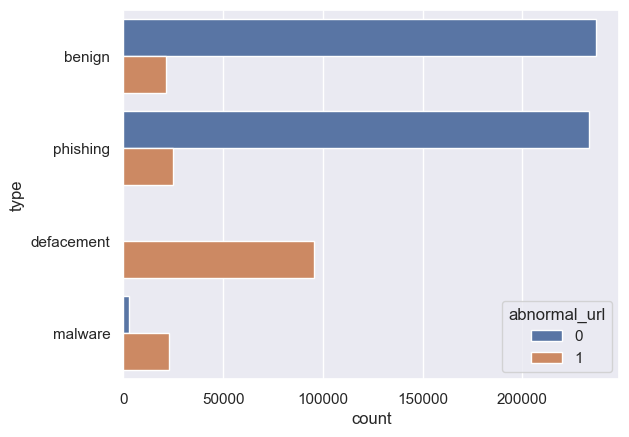

In [22]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")


## 4. Distribution of Shorl URL

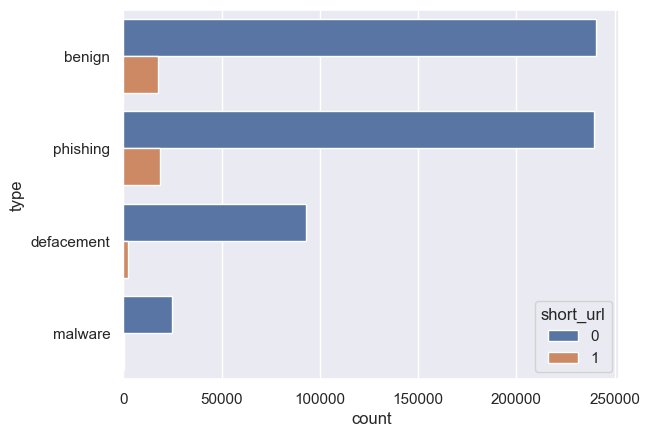

In [23]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")

## 5. Distribution of Suspicious URL

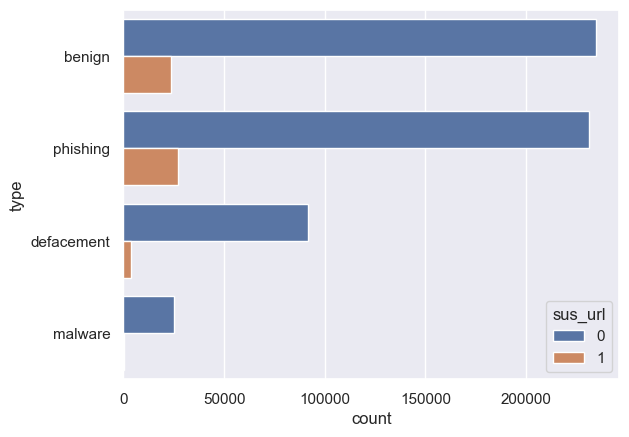

In [24]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")

## 8. Distribution of count@

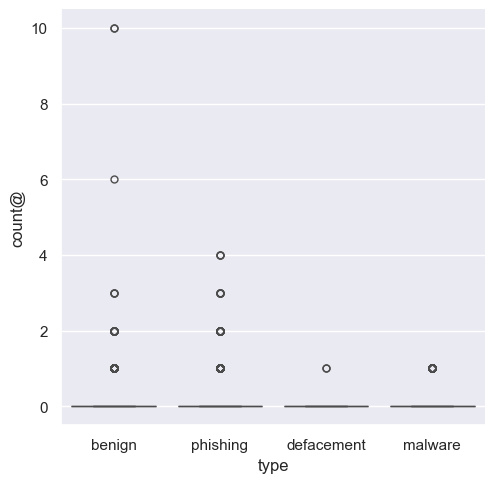

In [25]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count@", kind="box", data=df)

## 9. Distribution of count_dir

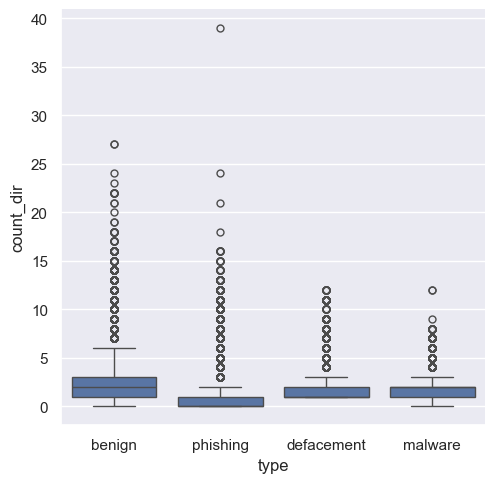

In [26]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df)

## 10. Distribution of hostname length

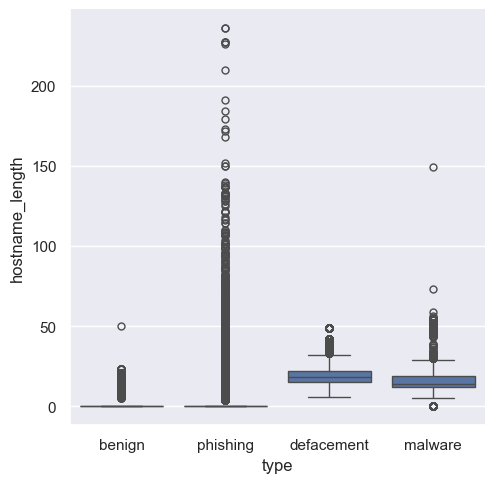

In [27]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

## 12. Distribution of top-level domain length

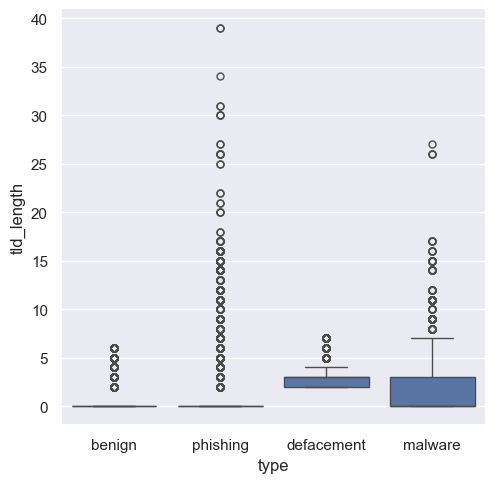

In [28]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)

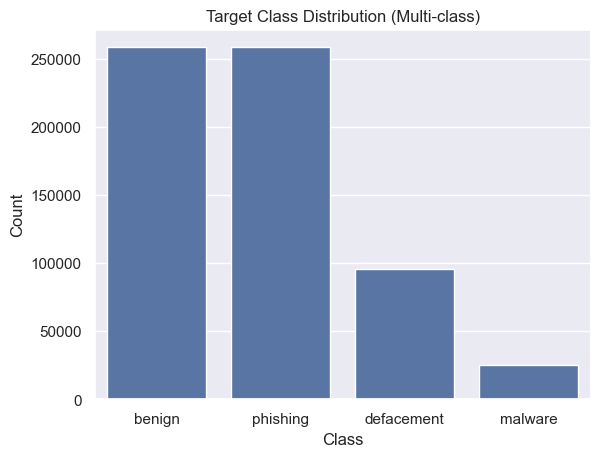


🔹 Class Percentage:
 type
benign        40.532698
phishing      40.532698
defacement    14.956788
malware        3.977816
Name: proportion, dtype: float64


In [29]:
# General class distribution (multi-class)
sns.countplot(x='type', data=df)
plt.title("Target Class Distribution (Multi-class)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Percentage of each class
print("\n🔹 Class Percentage:\n", df['type'].value_counts(normalize=True) * 100)


## Target Encoding

In [30]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'type' column
lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

# Count how many samples per class
print("Class counts:")
print(df["type_code"].value_counts())

# Create and print the mapping from code to label
label_map = dict(zip(lb_make.transform(lb_make.classes_), lb_make.classes_))
print("\nLabel Mapping (code -> label):")
for code, label in label_map.items():
    print(f"{code}: {label}")




Class counts:
type_code
0    258278
3    258278
1     95306
2     25347
Name: count, dtype: int64

Label Mapping (code -> label):
0: benign
1: defacement
2: malware
3: phishing


## Creation of Feature & Target 

In [31]:
#Predictor Variables
# Predictor Variables (Independent Features)
X = df[['use_of_ip', 'abnormal_url','url_entropy', 'count@',
       'count_dir', 'short_url', 'count-https', 'count-http', 'count?',
       'count-', 'count=', 'url_length', 'hostname_length', 'sus_url',
       'count-digits', 'count-letters', 'count_params',
       'tld_length', 'num_subdomains',
       'count_non_alphanumeric', 'has_php']]

#Target Variable
y = df['type_code']

## Train Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3,shuffle=True, random_state=5)

Class 0: 180795 samples
Class 1: 66714 samples
Class 2: 17743 samples
Class 3: 180794 samples

Class Distribution:
    Class   Count
0      0  180795
1      1   66714
2      2   17743
3      3  180794


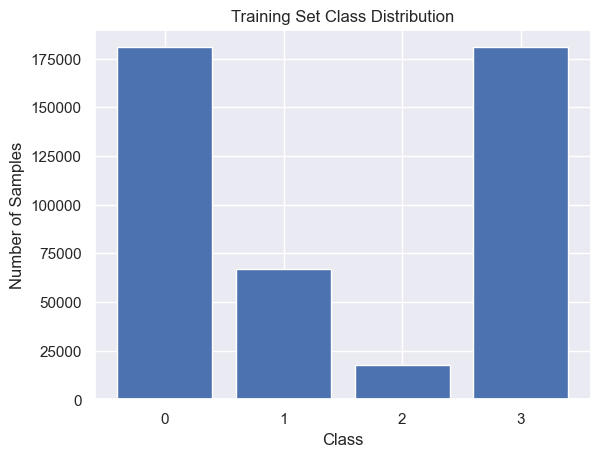

In [33]:
unique_classes, counts = np.unique(y_train, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} samples")

class_distribution = pd.DataFrame({
    'Class': unique_classes,
    'Count': counts
})

print("\nClass Distribution:\n", class_distribution)

import matplotlib.pyplot as plt
plt.bar(class_distribution['Class'].astype(str), class_distribution['Count'])
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


# Model Building 

## 1. Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['benign', 'defacement', 'phishing', 'malware']))
print("Test accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_rf)))

cross_val_scores = cross_val_score(rf, X_train, y_train, cv=5)
print("\nCross-validation scores: ", cross_val_scores)
print("Average cross-validation score: {:.4f}".format(cross_val_scores.mean()))



Classification Report:
              precision    recall  f1-score   support

      benign       0.94      0.96      0.95     77483
  defacement       0.97      0.99      0.98     28592
    phishing       0.84      0.90      0.87      7604
     malware       0.95      0.92      0.93     77484

    accuracy                           0.94    191163
   macro avg       0.92      0.94      0.93    191163
weighted avg       0.94      0.94      0.94    191163

Test accuracy: 0.9437

Cross-validation scores:  [0.94378433 0.9423937  0.94196774 0.94359314 0.94404152]
Average cross-validation score: 0.9432


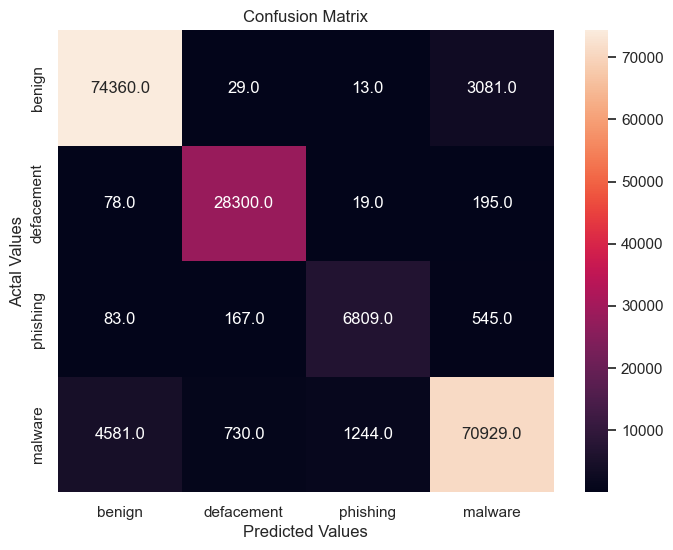

In [35]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

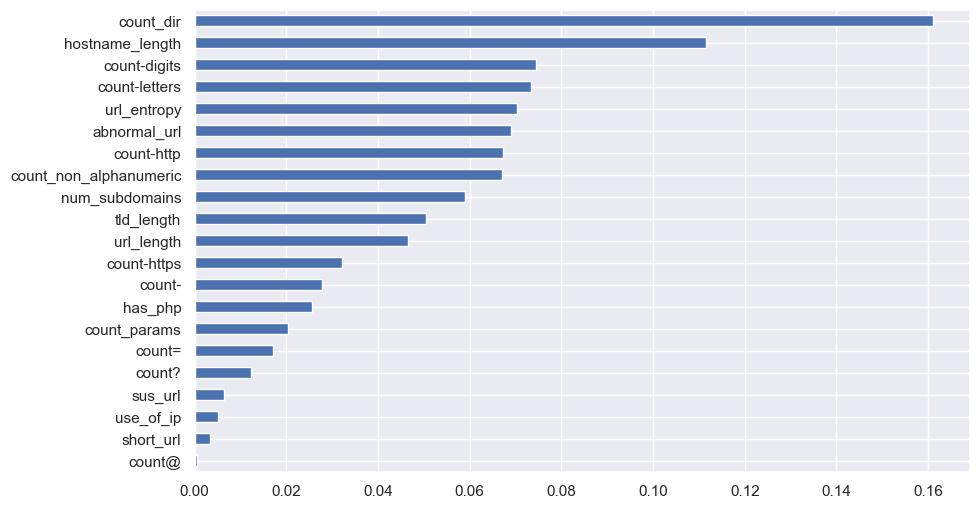

In [36]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

## 2. Light GBM Classifier

In [37]:
from sklearn.metrics import classification_report, accuracy_score
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',class_weight='balanced',n_jobs = 5, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1303
[LightGBM] [Info] Number of data points in the train set: 446046, number of used features: 21
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
              precision    recall  f1-score   support

      benign       0.93      0.96      0.95     77483
  defacement       0.94      0.99      0.96     28592
    phishing       0.75      0.92      0.82      7604
     malware       0.95      0.88      0.92     77484

    accuracy                           0.93    191163
   macro avg       0.89      0.94      0.91    191163
weighted avg       0.93      0.93      0.93    191

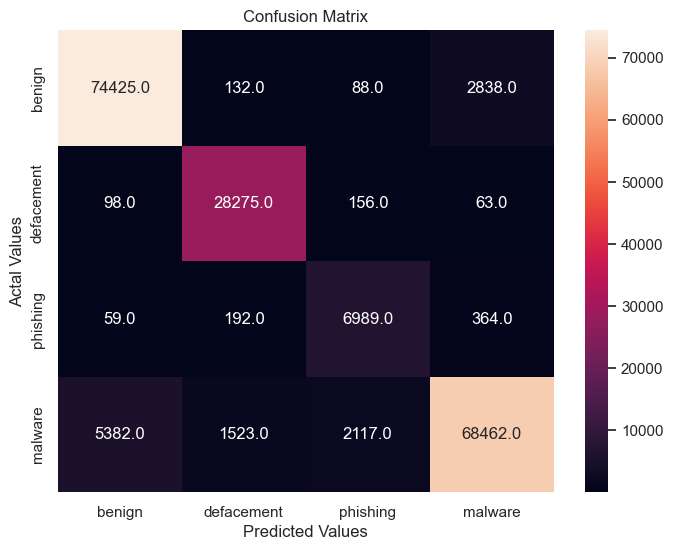

In [38]:
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


<Axes: >

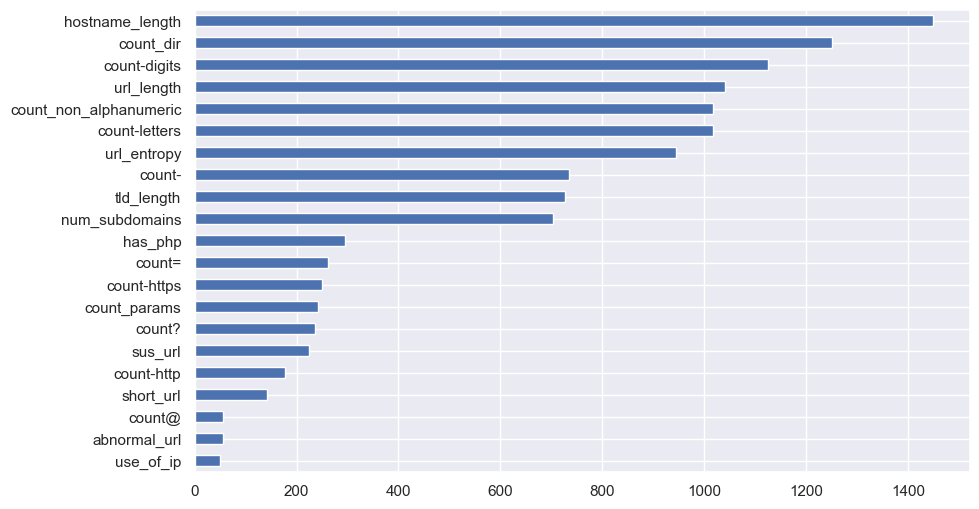

In [39]:
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

## 3. XGboost Classifier

In [40]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score


xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['benign', 'defacement', 'phishing', 'malware']))

accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy: %0.3f" % accuracy)


c:\Users\nanda\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:19:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

      benign       0.93      0.96      0.95     77483
  defacement       0.96      0.98      0.97     28592
    phishing       0.96      0.84      0.90      7604
     malware       0.95      0.92      0.93     77484

    accuracy                           0.94    191163
   macro avg       0.95      0.93      0.94    191163
weighted avg       0.94      0.94      0.94    191163

Accuracy: 0.944


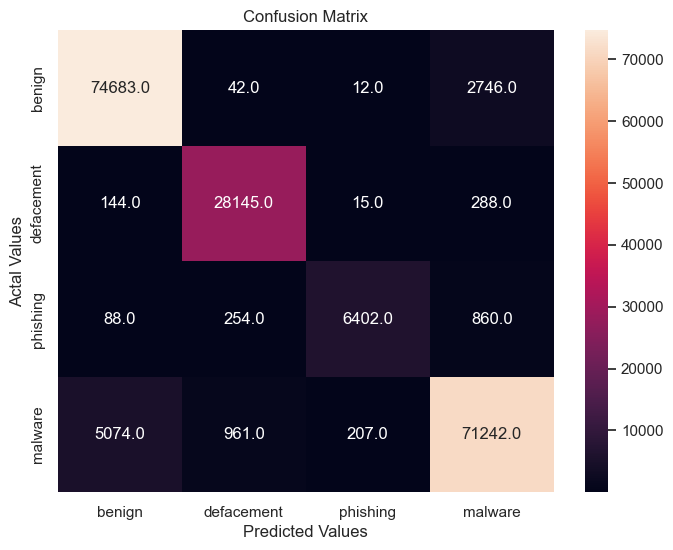

In [41]:
cm = confusion_matrix(y_test, y_pred_xgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

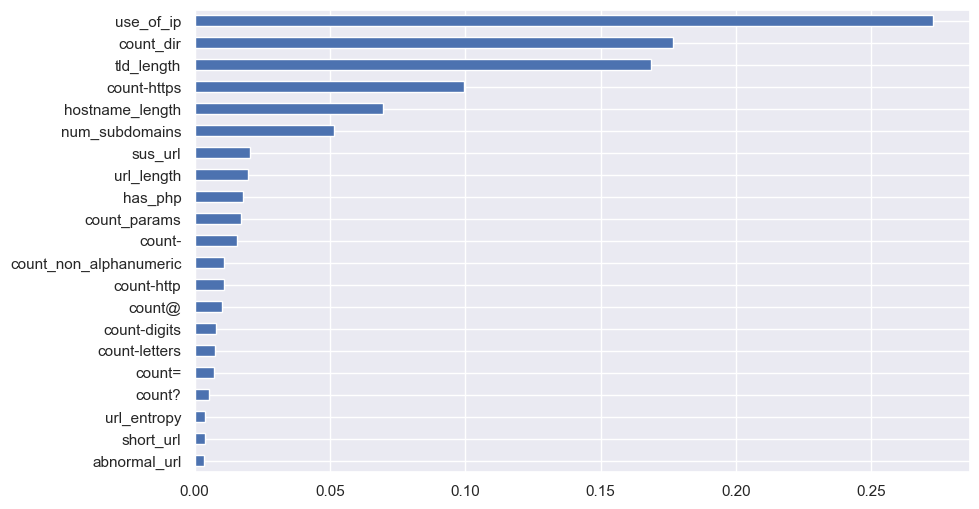

In [42]:
feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

In [43]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training accuracy
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Testing accuracy
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print("=== MODEL PERFORMANCE ===")
    print(f"Training Accuracy : {train_acc:.4f}")
    print(f"Testing Accuracy  : {test_acc:.4f}\n")

    print("=== CLASSIFICATION REPORT (Test Set) ===")
    print(classification_report(y_test, y_test_pred, target_names=['benign', 'defacement','phishing','malware']))

    # Basic overfitting/underfitting hint
    if train_acc > test_acc + 0.1:
        print("Model might be overfitting.")
    elif test_acc > train_acc + 0.1:
        print("Model might be underfitting.")
    else:
        print("Model is generalizing well.")



In [44]:
results = evaluate_model(rf, X_train, y_train, X_test, y_test)


=== MODEL PERFORMANCE ===
Training Accuracy : 0.9835
Testing Accuracy  : 0.9437

=== CLASSIFICATION REPORT (Test Set) ===
              precision    recall  f1-score   support

      benign       0.94      0.96      0.95     77483
  defacement       0.97      0.99      0.98     28592
    phishing       0.84      0.90      0.87      7604
     malware       0.95      0.92      0.93     77484

    accuracy                           0.94    191163
   macro avg       0.92      0.94      0.93    191163
weighted avg       0.94      0.94      0.94    191163

Model is generalizing well.


## Prediction

In [45]:
def main(url):
    status = []

    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(shannon_entropy(url))

    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))

    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(count_params(url))

    tld = get_tld(url, fail_silently=True)
    status.append(tld_length(tld))

    status.append(num_subdomains(url))
    status.append(count_non_alphanumeric(url))
    status.append(has_php(url))

    return status


In [53]:
label_map = {0: 'BENIGN', 1: 'DEFACEMENT', 2: 'MALWARE', 3: 'PHISHING'}

urls = [
    'https://gamma.app/docs/Optimizing-Music-Streaming-with-Floyd-Warshall-and-Backtracking-chxb1fx6ki12dh5?mode=doc',
    'en.wikipedia.org/wiki/North_Dakota',
    'https://abuse.ch/',
    '17e0de667d1213fb91cfa3710cab9129-dot-gle9392420309493993.rj.r.appspot.com','http://163.172.80.26/bins/sora.mpsl']

for url in urls:
    features = main(url)
    probs = xgb_model.predict_proba([features])[0]
    predicted_class = np.argmax(probs)
    predicted_label = label_map[predicted_class]
    confidence = probs[predicted_class]

    safety = "SAFE" if predicted_label == 'BENIGN' else "UNSAFE"

    print(f"\nURL: {url}")
    print(f"Prediction: {predicted_label} ({safety})")
    print(f"Confidence: {confidence:.4f}")
    print(f"Class Probabilities: ")
    print(f"  BENIGN:     {probs[0]:.4f}")
    print(f"  DEFACEMENT:{probs[1]:.4f}")
    print(f"  MALWARE:   {probs[2]:.4f}")
    print(f"  PHISHING:  {probs[3]:.4f}")



URL: https://gamma.app/docs/Optimizing-Music-Streaming-with-Floyd-Warshall-and-Backtracking-chxb1fx6ki12dh5?mode=doc
Prediction: BENIGN (SAFE)
Confidence: 0.9937
Class Probabilities: 
  BENIGN:     0.9937
  DEFACEMENT:0.0001
  MALWARE:   0.0002
  PHISHING:  0.0061

URL: en.wikipedia.org/wiki/North_Dakota
Prediction: BENIGN (SAFE)
Confidence: 0.6549
Class Probabilities: 
  BENIGN:     0.6549
  DEFACEMENT:0.0000
  MALWARE:   0.0004
  PHISHING:  0.3447

URL: https://abuse.ch/
Prediction: PHISHING (UNSAFE)
Confidence: 0.9834
Class Probabilities: 
  BENIGN:     0.0008
  DEFACEMENT:0.0001
  MALWARE:   0.0157
  PHISHING:  0.9834

URL: 17e0de667d1213fb91cfa3710cab9129-dot-gle9392420309493993.rj.r.appspot.com
Prediction: PHISHING (UNSAFE)
Confidence: 0.9992
Class Probabilities: 
  BENIGN:     0.0001
  DEFACEMENT:0.0000
  MALWARE:   0.0008
  PHISHING:  0.9992

URL: http://163.172.80.26/bins/sora.mpsl
Prediction: MALWARE (UNSAFE)
Confidence: 0.9952
Class Probabilities: 
  BENIGN:     0.0000
  DE

In [47]:
features = main("en.wikipedia.org/wiki/North_Dakota")
for i, val in enumerate(features):
    print(f"Feature {i}: {val}")


Feature 0: 0
Feature 1: 0
Feature 2: 3.973512753576009
Feature 3: 0
Feature 4: 2
Feature 5: 0
Feature 6: 0
Feature 7: 0
Feature 8: 0
Feature 9: 0
Feature 10: 0
Feature 11: 34
Feature 12: 0
Feature 13: 0
Feature 14: 0
Feature 15: 29
Feature 16: 0
Feature 17: 0
Feature 18: 1
Feature 19: 5
Feature 20: 0


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_and_plot_metrics(y_true, predictions_dict, average='weighted'):
    metrics_dict = {
        'Accuracy': {},
        'Precision': {},
        'Recall': {},
        'F1-Score': {}
    }

    for model_name, y_pred in predictions_dict.items():
        metrics_dict['Accuracy'][model_name] = accuracy_score(y_true, y_pred)
        metrics_dict['Precision'][model_name] = precision_score(y_true, y_pred, average=average)
        metrics_dict['Recall'][model_name] = recall_score(y_true, y_pred, average=average)
        metrics_dict['F1-Score'][model_name] = f1_score(y_true, y_pred, average=average)

    # Convert to long-format DataFrame for seaborn
    import pandas as pd
    plot_data = pd.DataFrame(metrics_dict).reset_index().melt(id_vars='index')
    plot_data.columns = ['Model', 'Metric', 'Score']

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_data, x='Metric', y='Score', hue='Model')
    
    # Set limits and improve label visibility
    plt.ylim(0, 1)  # Zoom into the critical range
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for clarity
    plt.title('Model Comparison on Classification Metrics')
    plt.ylabel('Score')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



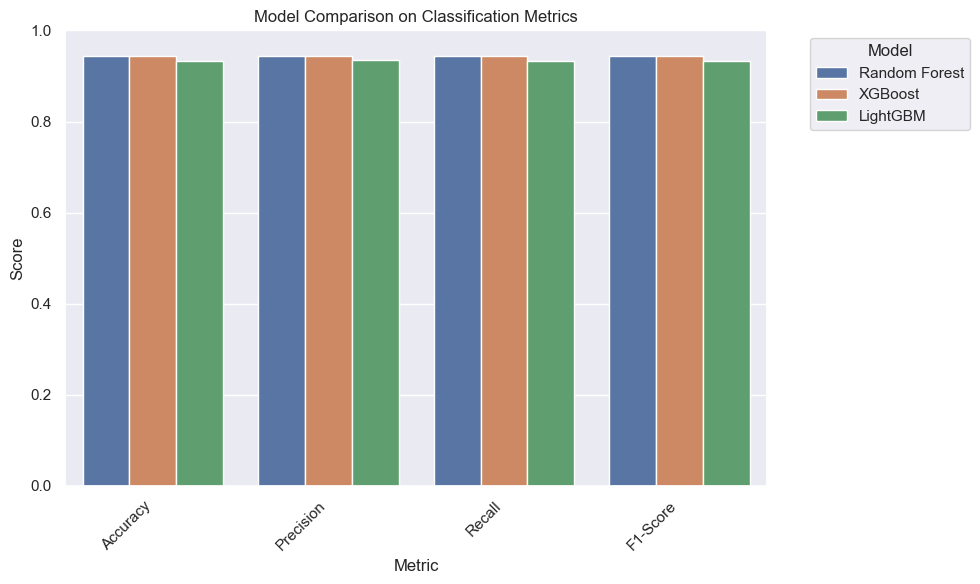

In [49]:
predictions_dict = {
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'LightGBM': y_pred_lgb
}

evaluate_and_plot_metrics(y_test, predictions_dict)


In [50]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

def get_combined_classification_summary(y_true, predictions_dict):
    rows = []
    for model_name, y_pred in predictions_dict.items():
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)

        avg_metrics = report.get("weighted avg", {})
        rows.append({
            'Model': model_name,
            'Precision': avg_metrics.get('precision', 0.0),
            'Recall': avg_metrics.get('recall', 0.0),
            'F1-Score': avg_metrics.get('f1-score', 0.0),
            'Accuracy': accuracy
        })

    return pd.DataFrame(rows)

# Usage:
combined_report_df = get_combined_classification_summary(y_test, predictions_dict)
print(combined_report_df)


           Model  Precision    Recall  F1-Score  Accuracy
0  Random Forest   0.943966  0.943687  0.943613  0.943687
1        XGBoost   0.944310  0.944074  0.943810  0.944074
2       LightGBM   0.934258  0.931932  0.931996  0.931932


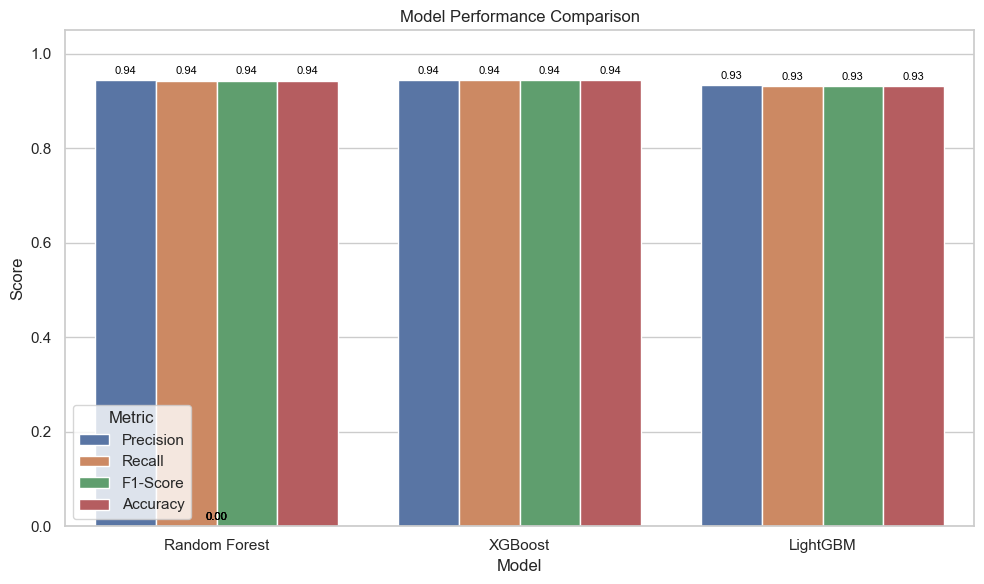

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure combined_report_df is already generated from your earlier code

# Melt the DataFrame to long format for seaborn
plot_df = combined_report_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Set style
sns.set(style="whitegrid")

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_df, x='Model', y='Score', hue='Metric')

# Add labels and title
plt.title('Model Performance Comparison')
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.xlabel('Model')

# Display values on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 3),
                textcoords='offset points')

# Save the figure as PNG
plt.tight_layout()

plt.show()


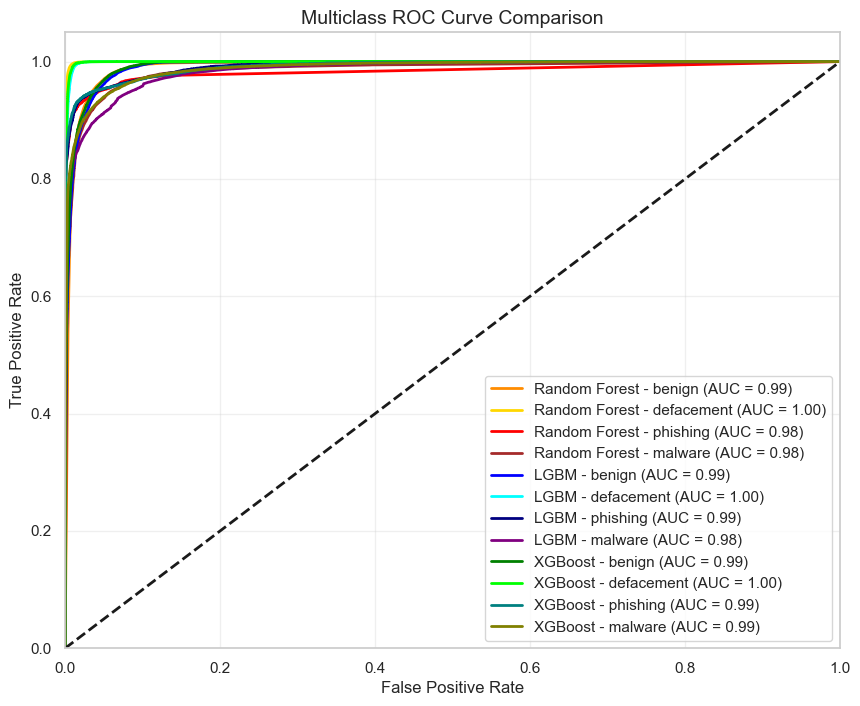

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Classes
class_names = ['benign', 'defacement', 'phishing', 'malware']

# Encode target labels and binarize
le = LabelEncoder()
y_encoded = le.fit_transform(y_test)
y_bin = label_binarize(y_encoded, classes=[0, 1, 2, 3])

# Predict probabilities for each model
rf_probs = rf.predict_proba(X_test)
lgbm_probs = lgb.predict_proba(X_test)
xgb_probs = xgb_model.predict_proba(X_test)

# Function to compute and plot ROC curves
def plot_multiclass_roc(y_true_bin, y_score, model_name, color):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color[i], lw=2,
                 label=f"{model_name} - {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plotting all models
plt.figure(figsize=(10, 8))
colors = [['darkorange', 'gold', 'red', 'brown'], ['blue', 'cyan', 'navy', 'purple'], ['green', 'lime', 'teal', 'olive']]

plot_multiclass_roc(y_bin, rf_probs, 'Random Forest', colors[0])
plot_multiclass_roc(y_bin, lgbm_probs, 'LGBM', colors[1])
plot_multiclass_roc(y_bin, xgb_probs, 'XGBoost', colors[2])

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multiclass ROC Curve Comparison', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
